In [8]:
from Dataset import *
from Model_Setting import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
plt.style.use('ggplot')
sns.set()
% matplotlib inline

Pre-trained GloVe word vectors are used to perform word embedding. Vector of length 25 is picked.

In [2]:
embedding_index, vtr_dim = import_glove(25)

In [234]:
col_fire_12 = dataset('2012_Colorado_wildfires/2012_Colorado_wildfires-tweets_labeled.csv')
col_flood_13 = dataset('2013_Colorado_floods/2013_Colorado_floods-tweets_labeled.csv')
aus_fire_13 = dataset('2013_Australia_bushfire/2013_Australia_bushfire-tweets_labeled.csv')
aus_flood_13 = dataset('2013_Queensland_floods/2013_Queensland_floods-tweets_labeled.csv')
col_fire_12_g = col_fire_12.glove(embedding_index, vtr_dim)
col_flood_13_g = col_flood_13.glove(embedding_index, vtr_dim)
aus_fire_13_g = aus_fire_13.glove(embedding_index, vtr_dim)
aus_flood_13_g = aus_flood_13.glove(embedding_index, vtr_dim)
col_fire_12_lb = to_categorical(col_fire_12.df.label)
col_flood_13_lb = to_categorical(col_flood_13.df.label)
aus_fire_13_lb = to_categorical(aus_fire_13.df.label)
aus_flood_13_lb = to_categorical(aus_flood_13.df.label)

Some useful functions here

In [5]:
def incremental_learning_prob(model, tweets, step=10, threshold=0.75):
    subset_len = tweets.shape[0]/step
    marks = [subset_len*i for i in range(step)]
    marks.append(tweets.shape[0])
    for i in range(step):
        text = tweets[marks[i]: marks[i+1]]
        y_pred = model.predict(x=text)
        x_confident = np.asarray([text[j] for j in range(len(y_pred)) if y_pred[j][0] >= threshold or y_pred[j][1] >= threshold])
        y_confident = [y_pred[j] for j in range(len(y_pred)) if y_pred[j][0] >= threshold or y_pred[j][1] >= threshold]
        label = to_categorical(map(lambda x: 0 if x[0]>=threshold else 1, y_confident))
        weight = np.array([(max(i)-0.5)/0.5 for i in y_confident])
        model.train_on_batch(x_confident, label, sample_weight=weight)#, validation_split=0.3, epochs = 10, callbacks=[EarlyStopping(patience=3)])

In [6]:
def incremental_learning_det(model, tweets, step=10, confidence=0.95):
    subset_len = tweets.shape[0]/step
    marks = [subset_len*i for i in range(step)]
    marks.append(tweets.shape[0])
    for i in range(step):
        text = tweets[marks[i]: marks[i+1]]
        y_pred = model.predict(x=text)
        x_confident = np.asarray([text[j] for j in range(len(y_pred)) if y_pred[j][0] >= confidence or y_pred[j][1] >= confidence])
        y_confident = [y_pred[j] for j in range(len(y_pred)) if y_pred[j][0] >= confidence or y_pred[j][1] >= confidence]
        label = to_categorical(map(lambda x: 0 if x[0]>=confidence else 1, y_confident))
        model.train_on_batch(x_confident, label)#, validation_split=0.3, epochs = 10, callbacks=[EarlyStopping(patience=3)])

In [126]:
def create_cnn_model(conv=[32, 16], window=[3,3], pool=3, dropout=0.3, penalty=0.01, input_shape=25, batch_normalize=False):
    model = Sequential()
    model.add(Conv1D(conv[0], window[0], activation='relu', kernel_initializer = 'he_normal', 
                   kernel_regularizer=regularizers.l2(penalty), input_shape=(None,input_shape)))
    model.add(MaxPooling1D(pool))
    model.add(Conv1D(conv[1], window[1], activation='relu', kernel_initializer = 'he_normal', 
                   kernel_regularizer=regularizers.l2(penalty)))
    model.add(GlobalMaxPooling1D())
    if batch_normalize:
        model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
def shuffle_train(model, data, text, path, k=10, n_epoch=10):
    min_val_loss = float('inf')
    n_earlystopping = [5]*(k/4)+[4]*(k/4)+[3]*(k/4)+[2]*(k-k/4*3)
    mcp_cnn = ModelCheckpoint(filepath=path, monitor='val_loss', save_best_only=True, save_weights_only=True)
    history = {'acc':[], 'loss':[], 'val_acc':[], 'val_loss':[]}
    ##### n_epoch*k epochs in total######
    for i in range(k):
        df = data.df.sample(frac=1)
        tweet_g = text[df.index.values]
        his = model.fit(tweet_g, to_categorical(df.label), callbacks=[EarlyStopping(monitor='val_loss', patience=n_earlystopping[i]),
                                mcp_cnn], validation_split=0.3, batch_size=64, epochs=n_epoch)
        for metric in ['acc', 'loss', 'val_acc', 'val_loss']:
            history[metric].extend(his.history[metric])
        if min(his.history['val_loss']) < min_val_loss:
            min_val_loss = min(his.history['val_loss'])
            model.load_weights(path)
        if len(his.history['acc']) > n_earlystopping[i]+1:
            stop = True
            for j in range(1,n_earlystopping[i]+1):
                if his.history['val_loss'][-j] < his.history['val_loss'][-j-1]:
                    stop = False
            if stop: break
    model.save(path)
    return history

In [223]:
def metric_drawing(title, path=None, Model=None):
    if Model is None:
        model = load_model(path)
    y_p1 = model.predict(col_flood_13_g)
    y_pred1 = []
    y_p2 = model.predict(aus_fire_13_g)
    y_pred2 = []
    y_p3 = model.predict(aus_flood_13_g)
    y_pred3 = []
    precision = []
    recall = []
    f1 = []
    for y in y_p1:
        if y[0]>y[1]:
            y_pred1.append(0)
        else:
            y_pred1.append(1)
    precision.append(metrics.precision_score(col_flood_13.df.label, y_pred1))
    recall.append(metrics.recall_score(col_flood_13.df.label, y_pred1))
    f1.append(metrics.f1_score(col_flood_13.df.label, y_pred1))
    for y in y_p2:
        if y[0]>y[1]:
            y_pred2.append(0)
        else:
            y_pred2.append(1)
    precision.append(metrics.precision_score(aus_fire_13.df.label, y_pred2))
    recall.append(metrics.recall_score(aus_fire_13.df.label, y_pred2))
    f1.append(metrics.f1_score(aus_fire_13.df.label, y_pred2))
    for y in y_p3:
        if y[0]>y[1]:
            y_pred3.append(0)
        else:
            y_pred3.append(1)
    precision.append(metrics.precision_score(aus_flood_13.df.label, y_pred3))
    recall.append(metrics.recall_score(aus_flood_13.df.label, y_pred3))
    f1.append(metrics.f1_score(aus_flood_13.df.label, y_pred3))

    plt.bar([0.9,1.9,2.9], precision, width=0.1, label='precision')
    plt.bar([1,2,3], recall, width=0.1, label='recall')
    plt.bar([1.1,2.1,3.1], f1, width=0.1, label='f1-score')
    plt.xticks([1,2,3], ['col_flood_13', 'aus_fire_13', 'aus_flood_13'])
    plt.ylim([0,1])
    plt.legend(loc='best')
    plt.xlabel('disaster')
    plt.ylabel('score')
    plt.title(title)
    plt.show()
    return precision, recall, f1

In [235]:
def plot_history(history, title):
    plt.figure(figsize=(16,6))
    plt.suptitle(title)
    plt.subplot(121)
    n_epoch = len(history.history['acc'])
    plt.plot(range(1, n_epoch+1), history.history['loss'], label='loss')
    plt.plot(range(1, n_epoch+1), history.history['val_loss'], label='val_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(range(1, n_epoch+1), history.history['acc'], label='acc')
    plt.plot(range(1, n_epoch+1), history.history['val_acc'], label='val_acc')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.show()

CNN: Normalization of word vector; Sample shuffle

In [170]:
cnn_model = create_cnn_model([8,4],[3,2],3, 0.2, 0.05, 25)

In [171]:
es = EarlyStopping(monitor='val_loss', patience=4)
mcp = ModelCheckpoint(filepath='cnn_unnormalized_unshuffle.h5', monitor='val_loss', save_best_only=True, save_weights_only=False)
history = cnn_model.fit(col_fire_12_g, to_categorical(col_fire_12.df.label), callbacks=[es,mcp], validation_split=0.3, batch_size=64, epochs=100)

Train on 781 samples, validate on 336 samples
Epoch 1/100
781/781 [==============================] - 6s 8ms/step - loss: 1.7644 - acc: 0.5442 - val_loss: 1.6538 - val_acc: 0.5357
Epoch 2/100
781/781 [==============================] - 0s 261us/step - loss: 1.5869 - acc: 0.5160 - val_loss: 1.5425 - val_acc: 0.5179
Epoch 3/100
781/781 [==============================] - 0s 278us/step - loss: 1.4944 - acc: 0.5173 - val_loss: 1.4601 - val_acc: 0.5119
Epoch 4/100
781/781 [==============================] - 0s 315us/step - loss: 1.4110 - acc: 0.5493 - val_loss: 1.3884 - val_acc: 0.5476
Epoch 5/100
781/781 [==============================] - 0s 288us/step - loss: 1.3392 - acc: 0.5685 - val_loss: 1.3238 - val_acc: 0.5655
Epoch 6/100
781/781 [==============================] - 0s 282us/step - loss: 1.2836 - acc: 0.5723 - val_loss: 1.2652 - val_acc: 0.5536
Epoch 7/100
781/781 [==============================] - 0s 294us/step - loss: 1.2193 - acc: 0.5800 - val_loss: 1.2107 - val_acc: 0.5655
Epoch 8/100

Epoch 61/100
781/781 [==============================] - 0s 277us/step - loss: 0.5800 - acc: 0.7913 - val_loss: 0.5711 - val_acc: 0.8244
Epoch 62/100
781/781 [==============================] - 0s 311us/step - loss: 0.5847 - acc: 0.7862 - val_loss: 0.5719 - val_acc: 0.8095
Epoch 63/100
781/781 [==============================] - 0s 261us/step - loss: 0.5715 - acc: 0.7990 - val_loss: 0.5690 - val_acc: 0.8125
Epoch 64/100
781/781 [==============================] - 0s 247us/step - loss: 0.5710 - acc: 0.8092 - val_loss: 0.5667 - val_acc: 0.8095
Epoch 65/100
781/781 [==============================] - 0s 248us/step - loss: 0.5712 - acc: 0.8067 - val_loss: 0.5662 - val_acc: 0.8125
Epoch 66/100
781/781 [==============================] - 0s 261us/step - loss: 0.5729 - acc: 0.8079 - val_loss: 0.5661 - val_acc: 0.8095
Epoch 67/100
781/781 [==============================] - 0s 256us/step - loss: 0.5583 - acc: 0.8233 - val_loss: 0.5656 - val_acc: 0.8006
Epoch 68/100
781/781 [==========================

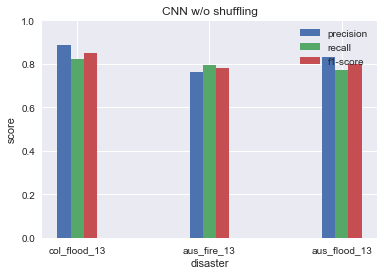

In [224]:
p, r, f = metric_drawing('CNN w/o shuffling', path='cnn_unnormalized_unshuffle.h5')

In [225]:
print p, r, f

[0.88593750000000004, 0.76480000000000004, 0.83116883116883122] [0.82054992764109991, 0.79401993355481726, 0.76992481203007523] [0.85199098422238917, 0.77913610431947844, 0.79937548790007806]


In [175]:
######################try hard label incremental learning####################################
cnn_model = load_model('cnn_unnormalized_unshuffle.h5')
print cnn_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))
incremental_learning_det(cnn_model, col_flood_13_g, step=10, confidence=0.85)
print cnn_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))

917/917 [==============================] - 3s 3ms/step
[0.58863933935290202, 0.78516902976883662]
917/917 [==============================] - 0s 138us/step
[0.53474661704628135, 0.80588876785082797]


In [176]:
cnn_model = load_model('cnn_unnormalized_unshuffle.h5')
print cnn_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))
incremental_learning_det(cnn_model, aus_fire_13_g, step=10, confidence=0.85)
print cnn_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))

1079/1079 [==============================] - 3s 2ms/step
[0.61980469172701336, 0.74884151998109794]
1079/1079 [==============================] - 0s 129us/step
[0.71965514017101562, 0.661723817797918]


In [177]:
cnn_model = load_model('cnn_unnormalized_unshuffle.h5')
print cnn_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))
incremental_learning_det(cnn_model, aus_flood_13_g, step=10, confidence=0.85)
print cnn_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))

1112/1112 [==============================] - 3s 3ms/step
[0.62559654601186299, 0.7688848916575205]
1112/1112 [==============================] - 0s 156us/step
[0.64015784881097804, 0.75539568302442706]


In [178]:
######################try weighted label incremental learning####################################
cnn_model = load_model('cnn_unnormalized_unshuffle.h5')
print cnn_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))
incremental_learning_prob(cnn_model, col_flood_13_g, step=10, threshold=0.75)
print cnn_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))

917/917 [==============================] - 3s 3ms/step
[0.58863933935290202, 0.78516902976883662]
917/917 [==============================] - 0s 150us/step
[0.5291610769968127, 0.80697928045672185]


In [179]:
cnn_model = load_model('cnn_unnormalized_unshuffle.h5')
print cnn_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))
incremental_learning_prob(cnn_model, aus_fire_13_g, step=10, threshold=0.75)
print cnn_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))

1079/1079 [==============================] - 3s 3ms/step
[0.61980469172701336, 0.74884151998109794]
1079/1079 [==============================] - 0s 138us/step
[0.70254257622419181, 0.66821130726268929]


In [180]:
cnn_model = load_model('cnn_unnormalized_unshuffle.h5')
print cnn_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))
incremental_learning_prob(cnn_model, aus_flood_13_g, step=10, threshold=0.75)
print cnn_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))

1112/1112 [==============================] - 3s 3ms/step
[0.62559654601186299, 0.7688848916575205]
1112/1112 [==============================] - 0s 120us/step
[0.61845626548039823, 0.76258992848636431]


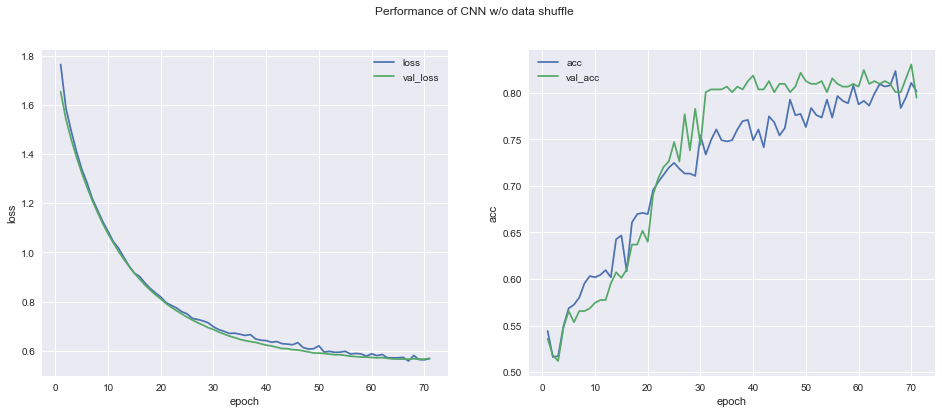

In [231]:
plt.figure(figsize=(16,6))
plt.suptitle('Performance of CNN w/o data shuffle')
plt.subplot(121)
n_epoch = len(history.history['acc'])
plt.plot(range(1, n_epoch+1), history.history['loss'], label='loss')
plt.plot(range(1, n_epoch+1), history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.subplot(122)
plt.plot(range(1, n_epoch+1), history.history['acc'], label='acc')
plt.plot(range(1, n_epoch+1), history.history['val_acc'], label='val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()

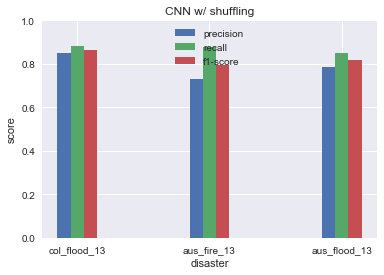

In [228]:
p, r, f = metric_drawing('CNN w/ shuffling', path='cnn_unnormalized_shuffle.h5')

In [229]:
print p, r, f

[0.8505586592178771, 0.72928176795580113, 0.78393351800554012] [0.88133140376266283, 0.87707641196013286, 0.85112781954887218] [0.86567164179104483, 0.79638009049773761, 0.81614996395097328]


In [253]:
cnn_model2 = create_cnn_model([8,4],[3,2],3, 0.2, 0.05, 25)

In [254]:
history2 = shuffle_train(cnn_model2, col_fire_12, col_fire_12_g, 'cnn_unnormalized_shuffle.h5')

Train on 781 samples, validate on 336 samples
Epoch 1/10
781/781 [==============================] - 9s 12ms/step - loss: 1.5617 - acc: 0.5621 - val_loss: 1.4984 - val_acc: 0.5952
Epoch 2/10
781/781 [==============================] - 0s 330us/step - loss: 1.4660 - acc: 0.5723 - val_loss: 1.4089 - val_acc: 0.6101
Epoch 3/10
781/781 [==============================] - 0s 320us/step - loss: 1.3794 - acc: 0.5698 - val_loss: 1.3302 - val_acc: 0.5952
Epoch 4/10
781/781 [==============================] - 0s 353us/step - loss: 1.3030 - acc: 0.5826 - val_loss: 1.2597 - val_acc: 0.5893
Epoch 5/10
781/781 [==============================] - 0s 317us/step - loss: 1.2338 - acc: 0.5787 - val_loss: 1.1974 - val_acc: 0.5893
Epoch 6/10
781/781 [==============================] - 0s 332us/step - loss: 1.1751 - acc: 0.5928 - val_loss: 1.1415 - val_acc: 0.5952
Epoch 7/10
781/781 [==============================] - 0s 372us/step - loss: 1.1206 - acc: 0.5980 - val_loss: 1.0932 - val_acc: 0.5923
Epoch 8/10
781/78

781/781 [==============================] - 0s 358us/step - loss: 0.5555 - acc: 0.8092 - val_loss: 0.5477 - val_acc: 0.8155
Epoch 3/10
781/781 [==============================] - 0s 351us/step - loss: 0.5618 - acc: 0.7849 - val_loss: 0.5484 - val_acc: 0.8244
Train on 781 samples, validate on 336 samples
Epoch 1/10
781/781 [==============================] - 0s 343us/step - loss: 0.5499 - acc: 0.8054 - val_loss: 0.5297 - val_acc: 0.8274
Epoch 2/10
781/781 [==============================] - 0s 376us/step - loss: 0.5489 - acc: 0.8079 - val_loss: 0.5313 - val_acc: 0.8155
Epoch 3/10
781/781 [==============================] - 0s 344us/step - loss: 0.5348 - acc: 0.8246 - val_loss: 0.5331 - val_acc: 0.8244
Train on 781 samples, validate on 336 samples
Epoch 1/10
781/781 [==============================] - 0s 331us/step - loss: 0.5700 - acc: 0.7772 - val_loss: 0.4981 - val_acc: 0.8393
Epoch 2/10
781/781 [==============================] - 0s 333us/step - loss: 0.5640 - acc: 0.8003 - val_loss: 0.5022

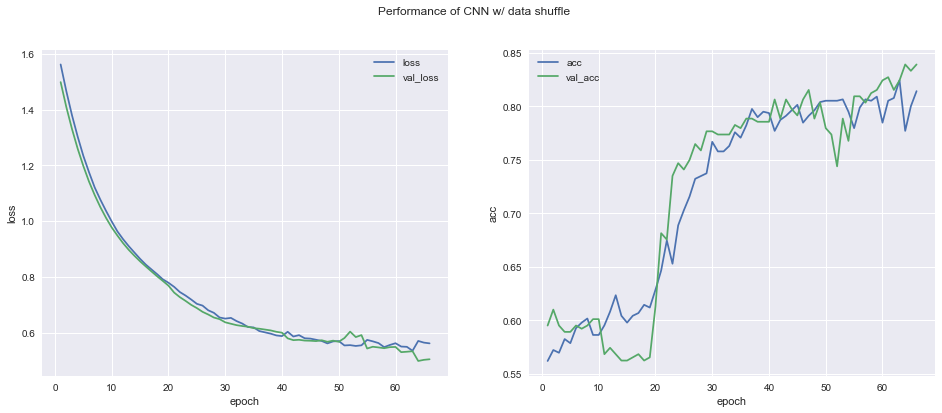

In [255]:
plt.figure(figsize=(16,6))
plt.suptitle('Performance of CNN w/ data shuffle')
plt.subplot(121)
n_epoch2 = len(history2['acc'])
plt.plot(range(1, n_epoch2+1), history2['loss'], label='loss')
plt.plot(range(1, n_epoch2+1), history2['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.subplot(122)
plt.plot(range(1, n_epoch2+1), history2['acc'], label='acc')
plt.plot(range(1, n_epoch2+1), history2['val_acc'], label='val_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()

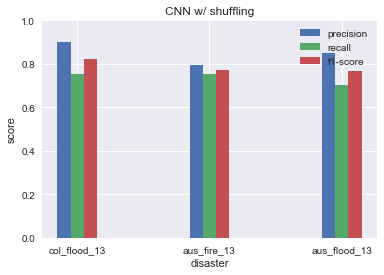

In [256]:
p, r, f = metric_drawing('CNN w/ shuffling', path='cnn_unnormalized_shuffle.h5')

In [251]:
print p, r, f

[0.87070376432078556, 0.71296296296296291, 0.82504288164665518] [0.76989869753979745, 0.76744186046511631, 0.72330827067669168] [0.81720430107526887, 0.73919999999999997, 0.77083333333333326]


In [200]:
######################try hard label incremental learning####################################
cnn_model = load_model('cnn_unnormalized_shuffle.h5')
print cnn_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))
incremental_learning_det(cnn_model, col_flood_13_g, step=10, confidence=0.8)
print cnn_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))

917/917 [==============================] - 3s 3ms/step
[0.56928150662939059, 0.79389313003099082]
917/917 [==============================] - 0s 151us/step
[0.53154476381830196, 0.7949836424418858]


In [201]:
cnn_model = load_model('cnn_unnormalized_shuffle.h5')
print cnn_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))
incremental_learning_det(cnn_model, aus_fire_13_g, step=10, confidence=0.8)
print cnn_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))

1079/1079 [==============================] - 3s 3ms/step
[0.62887721270516139, 0.74976830359848701]
1079/1079 [==============================] - 0s 135us/step
[0.72829406862462198, 0.60982391069728648]


In [202]:
cnn_model = load_model('cnn_unnormalized_shuffle.h5')
print cnn_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))
incremental_learning_det(cnn_model, aus_flood_13_g, step=10, confidence=0.8)
print cnn_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))

1112/1112 [==============================] - 3s 3ms/step
[0.6217174362793243, 0.77068345280859962]
1112/1112 [==============================] - 0s 134us/step
[0.65512704506194852, 0.70143884934967371]


In [198]:
######################try weighted label incremental learning####################################
cnn_model = load_model('cnn_unnormalized_shuffle.h5')
print cnn_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))
incremental_learning_prob(cnn_model, col_flood_13_g, step=10, threshold=0.8)
print cnn_model.evaluate(x=col_flood_13_g, y=to_categorical(col_flood_13.df.label))

917/917 [==============================] - 3s 3ms/step
[0.56928150662939059, 0.79389313003099082]
917/917 [==============================] - 0s 155us/step
[0.52765885996454542, 0.79716466752367421]


In [197]:
cnn_model = load_model('cnn_unnormalized_shuffle.h5')
print cnn_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))
incremental_learning_prob(cnn_model, aus_fire_13_g, step=10, threshold=0.8)
print cnn_model.evaluate(x=aus_fire_13_g, y=to_categorical(aus_fire_13.df.label))

1079/1079 [==============================] - 3s 3ms/step
[0.62887721270516139, 0.74976830359848701]
1079/1079 [==============================] - 0s 147us/step
[0.67435725874321895, 0.63855421736463558]


In [199]:
cnn_model = load_model('cnn_unnormalized_shuffle.h5')
print cnn_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))
incremental_learning_prob(cnn_model, aus_flood_13_g, step=10, threshold=0.8)
print cnn_model.evaluate(x=aus_flood_13_g, y=to_categorical(aus_flood_13.df.label))

1112/1112 [==============================] - 3s 3ms/step
[0.6217174362793243, 0.77068345280859962]
1112/1112 [==============================] - 0s 153us/step
[0.62506225983873542, 0.72032374057838389]


In [ ]:
keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB') # or'LR'

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))